In [5]:
import os
import numpy as np
import scipy
import sys
import matplotlib.gridspec as gridspec
import glob
from scipy.optimize import curve_fit
from astropy.io import fits
import matplotlib.pyplot as plt
import emcee
import corner
from tabulate import tabulate
%matplotlib inline

## 1. Image

In [2]:
hdul = fits.open('/home/tehan/Documents/ShaneAO/Binaries/TIC_456334158_final_filter_Ks.fits')

212 264


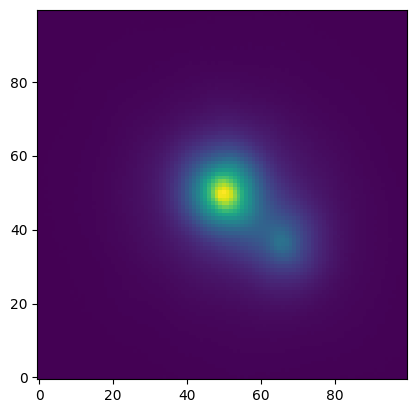

In [67]:
image = hdul[0].data
peak = np.where(image == np.max(image))
delta_x = peak[0][0] - 50
delta_y = peak[1][0] - 50
print(delta_x, delta_y)
image = hdul[0].data[delta_x:delta_x+100, delta_y:delta_y+100]
peak = np.where(image == np.max(image))
np.shape(image)
plt.imshow(image, origin='lower')
# plt.xlim(250,350)
# plt.ylim(200,300)

## 2. scipy curve_fit

Fitted parameters for Gaussian 1:
Amplitude: 672.5164629060043
Mean (x, y): 49.61292983747325 50.25979351326851
Standard deviation (sigma_x, sigma_y): 6.980319434033407 7.642109579313295

Fitted parameters for Gaussian 2:
Amplitude: 230.33532075781045
Mean (x, y): 65.32770721711672 37.49848629876259
Standard deviation (sigma_x, sigma_y): 9.111800489825244 10.310143365511145


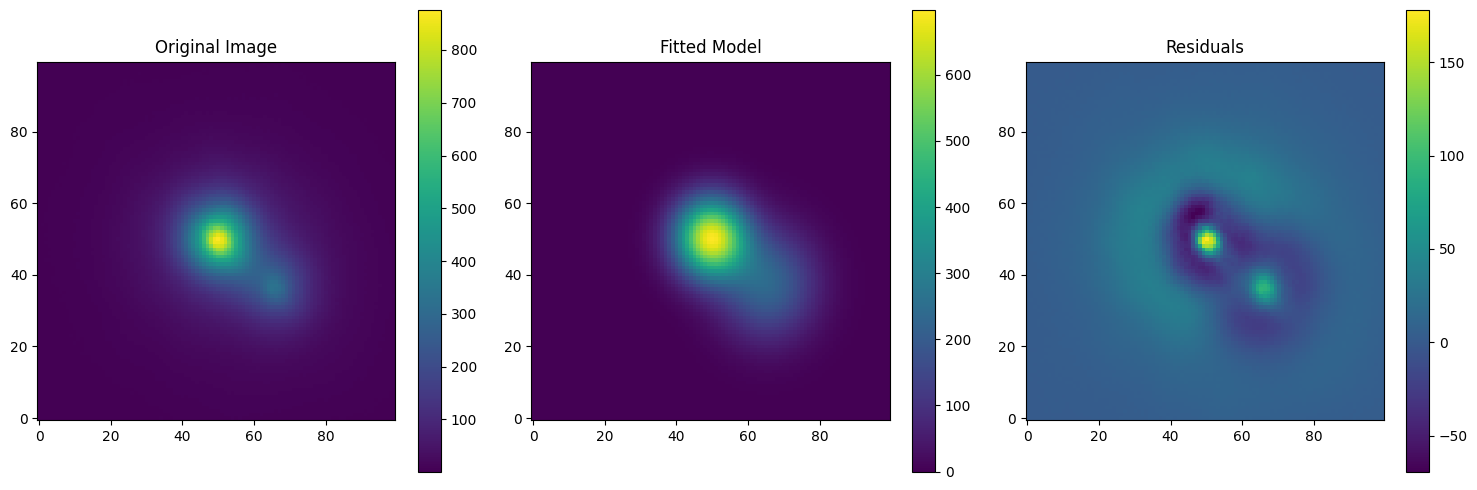

In [69]:
x, y = np.meshgrid(np.arange(np.shape(image)[0]), np.arange(np.shape(image)[1]))
# Define a function to represent the double Gaussian
def double_gaussian(xy, amp1, x_mean1, y_mean1, sigma_x1, sigma_y1, amp2, x_mean2, y_mean2, sigma_x2, sigma_y2):
    x, y = xy
    gauss1 = amp1 * np.exp(-((x - x_mean1) ** 2 / (2 * sigma_x1 ** 2) + (y - y_mean1) ** 2 / (2 * sigma_y1 ** 2)))
    gauss2 = amp2 * np.exp(-((x - x_mean2) ** 2 / (2 * sigma_x2 ** 2) + (y - y_mean2) ** 2 / (2 * sigma_y2 ** 2)))
    return gauss1 + gauss2

# Initial guess for parameters
initial_guess = [np.max(image), peak[1][0], peak[0][0], 4, 4, 
                 np.max(image) / 10, 330 - delta_y, 250 - delta_x, 0.5, 0.5]

# Fit the double Gaussian model to the data
popt, pcov = curve_fit(double_gaussian, (x.ravel(), y.ravel()), image.ravel(), p0=initial_guess)

# Extracting fitted parameters
amp1, x_mean1, y_mean1, sigma_x1, sigma_y1, amp2, x_mean2, y_mean2, sigma_x2, sigma_y2 = popt

# Calculate the fitted model and residuals
fitted_model = double_gaussian((x, y), *popt)
residuals = image - fitted_model

# Print fitted parameters
print("Fitted parameters for Gaussian 1:")
print("Amplitude:", amp1)
print("Mean (x, y):", x_mean1, y_mean1)
print("Standard deviation (sigma_x, sigma_y):", sigma_x1, sigma_y1)
print("\nFitted parameters for Gaussian 2:")
print("Amplitude:", amp2)
print("Mean (x, y):", x_mean2, y_mean2)
print("Standard deviation (sigma_x, sigma_y):", sigma_x2, sigma_y2)

# Plot the original image, the fitted model, and the residuals
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image, origin='lower', cmap='viridis', interpolation='nearest')
plt.title('Original Image')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(fitted_model, origin='lower', cmap='viridis', interpolation='nearest')
plt.title('Fitted Model')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(residuals, origin='lower', cmap='viridis', interpolation='nearest')
plt.title('Residuals')
plt.colorbar()

plt.tight_layout()
plt.show()

## 3. emcee

100%|██████████| 10000/10000 [00:40<00:00, 249.52it/s]


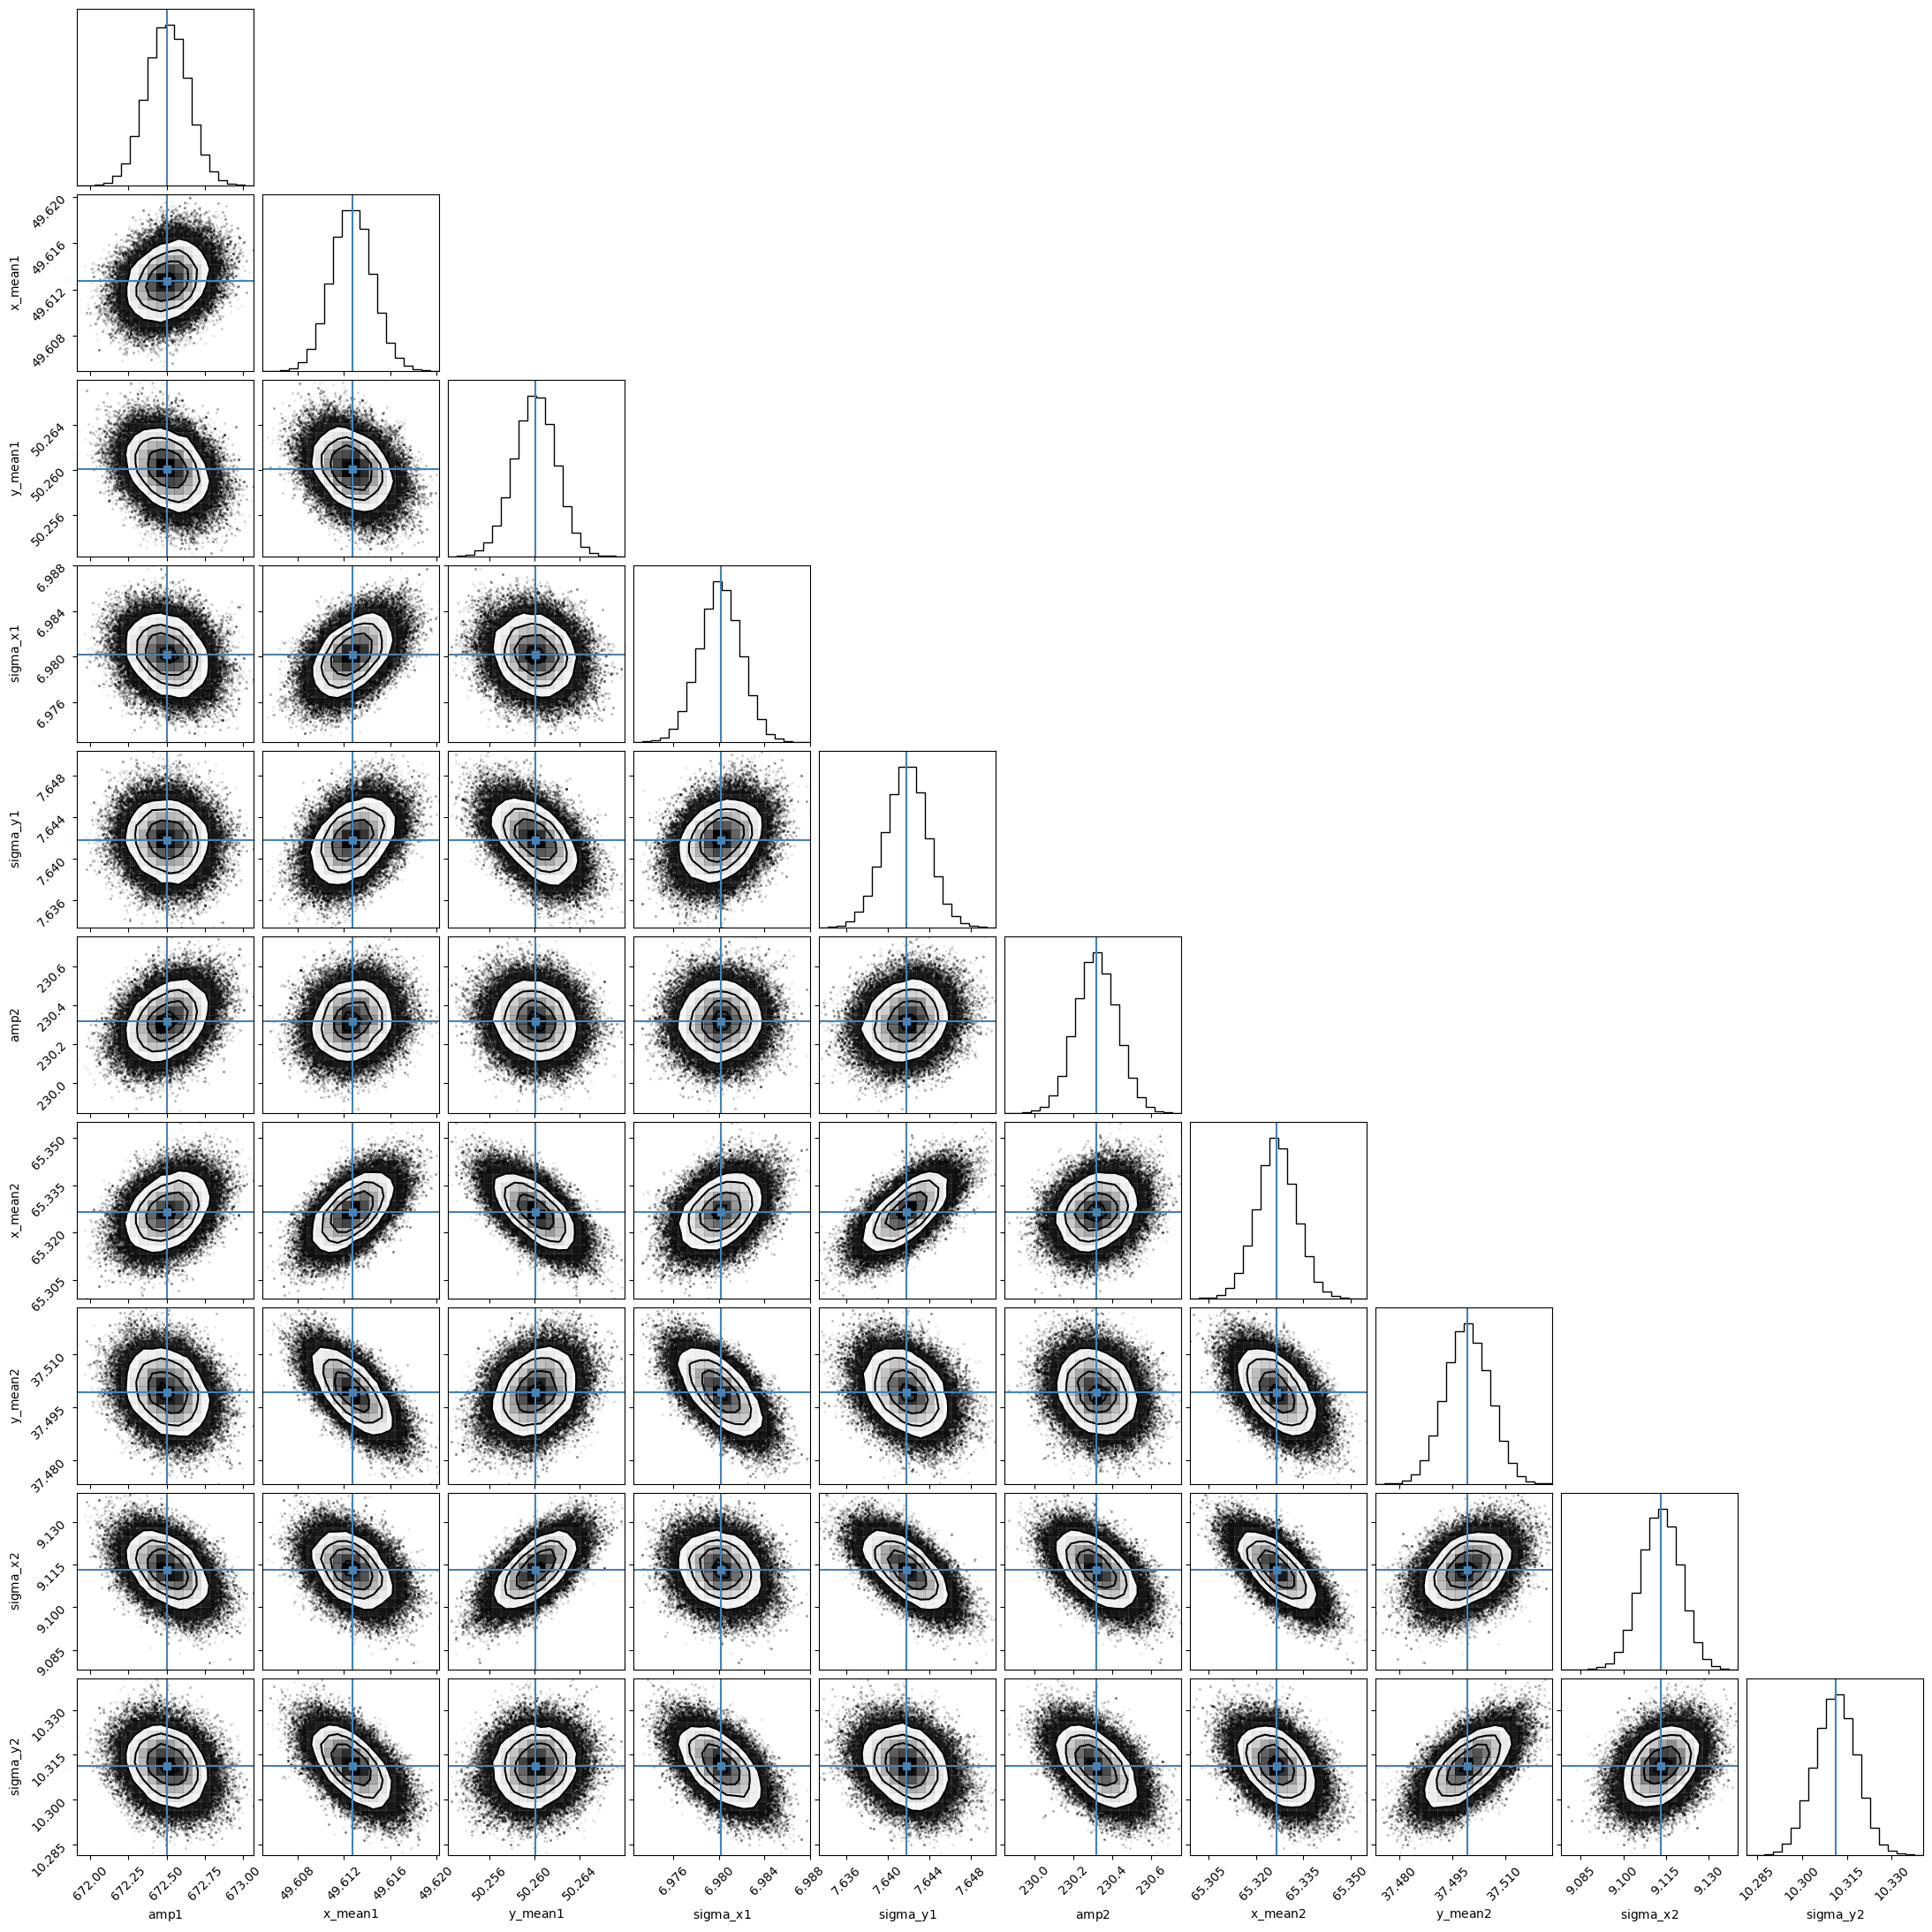

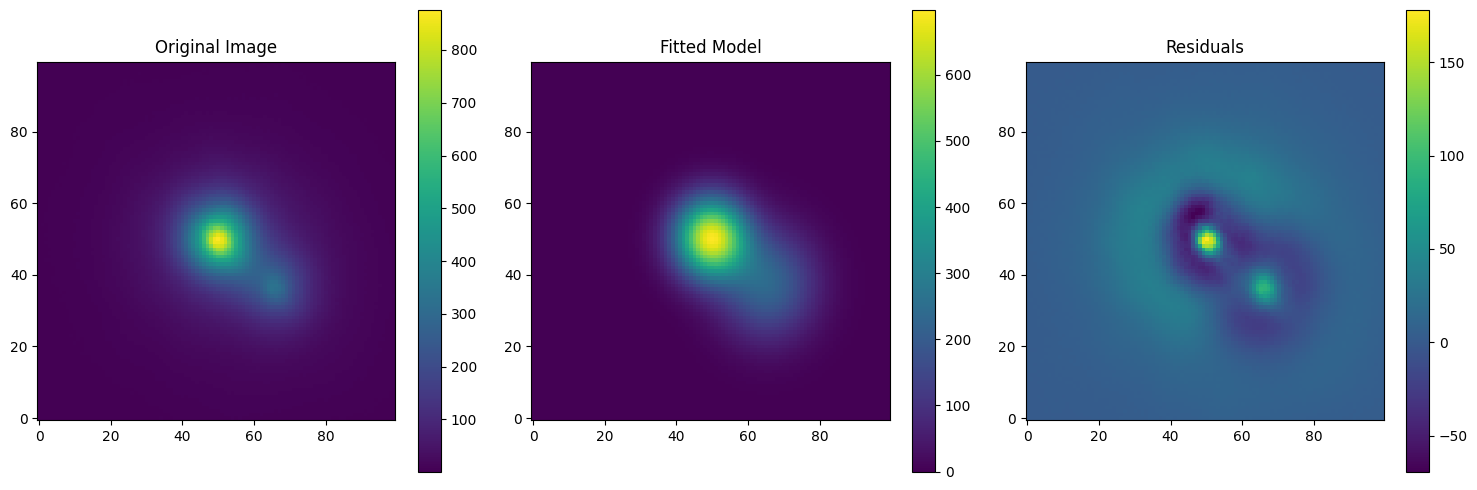

\begin{tabular}{lrr}
\hline
 Parameter            &      Mean &   Std. Dev. \\
\hline
 $\mathrm{amp1}$      & 672.504   &  0.135038   \\
 $\mathrm{x\_mean1}$  &  49.6127  &  0.00176746 \\
 $\mathrm{y\_mean1}$  &  50.26    &  0.001859   \\
 $\mathrm{sigma\_x1}$ &   6.98013 &  0.00182611 \\
 $\mathrm{sigma\_y1}$ &   7.6418  &  0.00204496 \\
 $\mathrm{amp2}$      & 230.32    &  0.104982   \\
 $\mathrm{x\_mean2}$  &  65.3266  &  0.00629115 \\
 $\mathrm{y\_mean2}$  &  37.4994  &  0.00622202 \\
 $\mathrm{sigma\_x2}$ &   9.11326 &  0.00691799 \\
 $\mathrm{sigma\_y2}$ &  10.3113  &  0.00696249 \\
\hline
\end{tabular}


In [71]:
# Initial guess for parameters from previous
initial_guess = popt

# Define log likelihood function for the MCMC sampler
def log_likelihood(params, xy, data):
    model = double_gaussian(xy, *params)
    return -0.5 * np.sum((data - model)**2)

# Define log prior function for the MCMC sampler
def log_prior(params):
    # Assuming flat priors for all parameters
    return 0.0

# Define log probability function for the MCMC sampler
def log_probability(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, (x.ravel(), y.ravel()), image.ravel())

# Set up the MCMC sampler
nwalkers = 32
ndim = len(initial_guess)
nsteps = 10000
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

# Initialize walkers
p0 = [initial_guess + 1e-4 * np.random.randn(ndim) for _ in range(nwalkers)]

# Run the MCMC sampler
sampler.run_mcmc(p0, nsteps, progress=True)

# Get samples from the MCMC chain, discarding the burn-in period
burn_in = int(0.2 * nsteps)  # Define the burn-in period as 20% of the total steps
samples = sampler.get_chain(flat=True, discard=burn_in)

# Extract mean and standard deviation of parameters from samples
param_means = np.mean(samples, axis=0)
param_std = np.std(samples, axis=0)

# Plot corner plot to visualize parameter distributions
labels = [r"$\mathrm{amp1}$", r"$\mathrm{x\_mean1}$", r"$\mathrm{y\_mean1}$",
          r"$\mathrm{sigma\_x1}$", r"$\mathrm{sigma\_y1}$", r"$\mathrm{amp2}$",
          r"$\mathrm{x\_mean2}$", r"$\mathrm{y\_mean2}$", r"$\mathrm{sigma\_x2}$",
          r"$\mathrm{sigma\_y2}$"]
corner_plot = corner.corner(samples, labels=labels, truths=param_means, figsize=(10, 10))

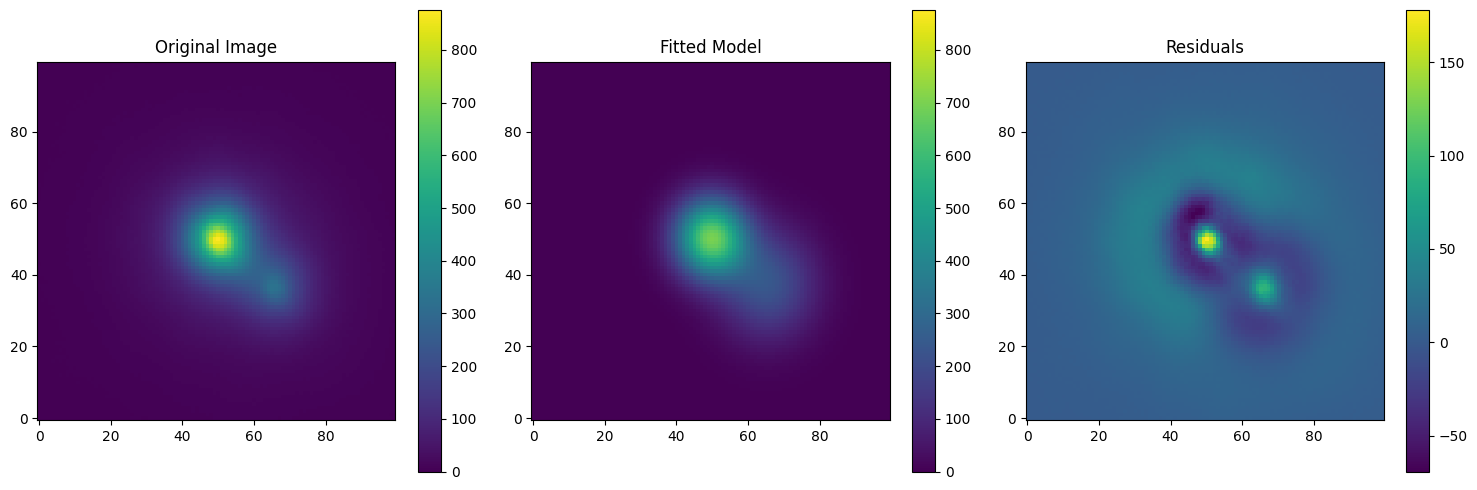

\begin{tabular}{lrr}
\hline
 Parameter            &      Mean &   Std. Dev. \\
\hline
 $\mathrm{amp1}$      & 672.504   &  0.135038   \\
 $\mathrm{x\_mean1}$  &  49.6127  &  0.00176746 \\
 $\mathrm{y\_mean1}$  &  50.26    &  0.001859   \\
 $\mathrm{sigma\_x1}$ &   6.98013 &  0.00182611 \\
 $\mathrm{sigma\_y1}$ &   7.6418  &  0.00204496 \\
 $\mathrm{amp2}$      & 230.32    &  0.104982   \\
 $\mathrm{x\_mean2}$  &  65.3266  &  0.00629115 \\
 $\mathrm{y\_mean2}$  &  37.4994  &  0.00622202 \\
 $\mathrm{sigma\_x2}$ &   9.11326 &  0.00691799 \\
 $\mathrm{sigma\_y2}$ &  10.3113  &  0.00696249 \\
\hline
\end{tabular}


In [74]:
# Extract parameter names
param_names = [r"$\mathrm{amp1}$", r"$\mathrm{x\_mean1}$", r"$\mathrm{y\_mean1}$",
               r"$\mathrm{sigma\_x1}$", r"$\mathrm{sigma\_y1}$", r"$\mathrm{amp2}$",
               r"$\mathrm{x\_mean2}$", r"$\mathrm{y\_mean2}$", r"$\mathrm{sigma\_x2}$",
               r"$\mathrm{sigma\_y2}$"]

# Combine parameter names, means, and standard deviations into a table
table_data = [[name, mean, std] for name, mean, std in zip(param_names, param_means, param_std)]

# Print the table in LaTeX style
latex_table = tabulate(table_data, headers=["Parameter", "Mean", "Std. Dev."], tablefmt="latex_raw")

# Plot the original image, the fitted model, and the residuals
plt.figure(figsize=(15, 5))
cmin = min(np.min(image), np.min(fitted_model))
cmax = max(np.max(image), np.max(fitted_model))
# Plot the original image
plt.subplot(1, 3, 1)
im = plt.imshow(image, origin='lower', cmap='viridis', interpolation='nearest', vmin=cmin, vmax=cmax)
plt.title('Original Image')
plt.colorbar(im)

# Plot the fitted model
fitted_model = double_gaussian((x, y), *param_means)
plt.subplot(1, 3, 2)
im = plt.imshow(fitted_model, origin='lower', cmap='viridis', interpolation='nearest', vmin=cmin, vmax=cmax)
plt.title('Fitted Model')
plt.colorbar(im)

# Plot the residuals
residuals = image - fitted_model
plt.subplot(1, 3, 3)
im = plt.imshow(residuals, origin='lower', cmap='viridis', interpolation='nearest')
plt.title('Residuals')
plt.colorbar(im)

# Adjust colorbar limits to match the first two plots


plt.tight_layout()
plt.show()

# Print the LaTeX table
print(latex_table)